# Projeto 1 - Ciência dos Dados

Nome: <font color = "red">Greta Faria</font>

Nome: <font color = "red">Maria Luiza Sevilha</font>

Atenção: Serão permitidos grupos de três pessoas, mas com uma rubrica mais exigente. Grupos deste tamanho precisarão fazer um questionário de avaliação de trabalho em equipe

___
Carregando algumas bibliotecas:

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re 

In [2]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
c:\Users\malus\CeDados\Naive_Bayes


Carregando a base de dados com os tweets classificados manualmente:

In [3]:
train = pd.read_excel('dados_treino_bruto.xlsx')
train.head(5)

,Mensagem,Target
0,Gostei muito do livro. Prende a nossa atenção ...,Outros
1,Eu não compro esse livro!,Outros
2,"Livro de agradável leitura, bastante esclarece...",Outros
3,"Gostei mais de Sapiens, uma leitura mais bioló...",Outros
4,Não gostei,Outros


In [4]:
test = pd.read_excel('dados_teste_bruto.xlsx')
test.head(5)

,Mensagem,Target
0,"Sou fã do canal, estava na primeira sessão da ...",Todos
1,Os fatos históricos relatados dão conhecimento...,Outros
2,"Gostei de tudo, é engraçado dois personagem di...",Outros
3,Tão emocionante quanto o primeiro volume. Dand...,Outros
4,O título sugere algo mais profundo e nos induz...,Outros


___
## Classificador automático


Faça aqui uma descrição do seu assunto e o que considerou como relevante ou não relevante na classificação dos tweets (Target).

O assunto abordado nas mensagens geradas são críticas de livros. Pensando nisso, desenvolvemos um classificador que direcionado pela divisão entre criticas direcionadas ao conteúdo do livro - podendo elas estarem relacionadas a percepção do livro como "fraco", ou a uma discordância do usuário com o assunto abordado, não compactuando com o que é dito - e ao processo de entrega.

___
### Montando um Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

#### <u>Criando *DataFrames*</u>

Fazendo inicialmente uma função para limpar as mensagens

In [5]:
# Importando a função cleanup
def cleanup(text):
    """
        Função de limpeza muito simples que troca alguns sinais básicos por espaços
    """
    #import string
    punctuation = '[´"!-.:?;$'']' # Note que os sinais [] são delimitadores de um conjunto.
    pattern = re.compile(punctuation)
    text_subbed = re.sub(pattern, '', text)
    return text_subbed

# Testando a função de limpar mensagens
texto = 'A não ´ " ser que haja ! várias : pontuações ; excluir tudo ? não de novo A que haja haja haja ❤'
print("Texto bruto: ", texto)
print("Testo limpo: ", cleanup(texto))

Texto bruto:  A não ´ " ser que haja ! várias : pontuações ; excluir tudo ? não de novo A que haja haja haja ❤
Testo limpo:  A não   ser que haja  várias  pontuações  excluir tudo  não de novo A que haja haja haja ❤


Agora, com essa função, precisamos dividir o nosso DataFrame "**train**" em três: um para a categoria "*fraco*", outro para a categoria "*entrega*" e outro para categoria "*discordou*". 

In [6]:
# Criando o DataFrame Fraco
filtro_fraco = ((train['Target'] == 'Fraco') | (train['Target'] == 'Fraco e Discordou') | (train['Target'] == 'Entrega e Fraco') | (train['Target'] == 'Todos'))
fraco = train.loc[filtro_fraco, :]

# Criando o DataFrame Discordou
filtro_discordou =  ((train['Target'] == 'Discordou') | (train['Target'] == 'Fraco e Discordou') | (train['Target'] == 'Entrega e Discordou') | (train['Target'] == 'Todos'))
discordou = train.loc[filtro_discordou, : ]

# Criando o DataFrame Entrega
filtro_entrega =  ((train['Target'] == 'Entrega') | (train['Target'] == 'Entrega e Discordou') | (train['Target'] == 'Entrega e Fraco') | (train['Target'] == 'Todos'))
entrega = train.loc[filtro_entrega, :]

Agora vamos conferir os nossos dataframes:

In [7]:
# Conferindo o fraco
fraco.head(5)

,Mensagem,Target
16,"O livro está datado, não serve para os dias de...",Fraco e Discordou
17,"Bobagem, 70% do livro são descrições de ""trepa...",Fraco e Discordou
18,"A proposta do livro é legal, a ideia num geral...",Fraco e Discordou
19,Perdi tempo de ler autores como Gilberto Freyr...,Fraco e Discordou
20,Pra mim isso nem pode ser chamado de livro. A ...,Fraco e Discordou


In [8]:
# Conferindo o discordou
discordou.head(5)

,Mensagem,Target
16,"O livro está datado, não serve para os dias de...",Fraco e Discordou
17,"Bobagem, 70% do livro são descrições de ""trepa...",Fraco e Discordou
18,"A proposta do livro é legal, a ideia num geral...",Fraco e Discordou
19,Perdi tempo de ler autores como Gilberto Freyr...,Fraco e Discordou
20,Pra mim isso nem pode ser chamado de livro. A ...,Fraco e Discordou


In [9]:
# Conferindo o entrega
entrega.head(5)

,Mensagem,Target
131,Não consegui passar da metade. É bem sem graça...,Entrega e Fraco
132,Não foi exatamente o que eu esperava. Tem muit...,Entrega e Fraco
133,"A história era boa em 3 volumes, e mesmo a nov...",Entrega e Fraco
134,"Livro mal escrito, mal traduzido, enredo confu...",Entrega e Fraco
135,"Num mosteiro italiano em 1300, ocorreram algum...",Entrega e Fraco


Com os três dataframes criados, podemos partir para a próxima etapa!

#### <u>Criando o "português"</u>

Para fazermos o classificador, partimos da <b>suposição ingênua</b> de que todas as palavras do português estão contidas no nosso dataframe *train* com todas as mensagens. Assim:

In [10]:
# Criando uma lista com todas as palavras do português
portugues_bruto = list(train["Mensagem"])
portugues = []

for mensagem in portugues_bruto:
    mensagem = cleanup(mensagem.lower())
    mensagem = mensagem.split()

    for palavra in mensagem:
        portugues.append(palavra)

# Tranformando a lista em uma série
serie_portugues = pd.Series(portugues)

# Transformando a série em uma tabela com as frequências relativas de cada palavra
tabela_portugues_relativa = serie_portugues.value_counts(True)

# Testando para ver como está a nossa tabela
tabela_portugues_relativa.head()

o      0.034144
de     0.033905
a      0.031820
que    0.031760
e      0.030568
dtype: float64

Com o português criado, podemos começar a analisar os nossos dataframes, um por um.

#### <u>Criando a tabela de frequências relativas dos dataframes</u>

As frequências relativas nos mostram a porcentagem de vezes que uma palavra aparece, dentro da amostra analisada. Essa porcentagem também pode ser analisada como a probabilidade de, dado que foi-se escolhida uma palavra qualquer, essa ser uma específica.

##### Por exemplo:
nas frequências relativas do português vemos que a palavra "que" tem 3.2% de aparição, dentre todas as mensagens. Assim, se fossemos escolher uma palavra qualquer dos dados colocados para realizar o dataframe português (o *DataFrame* train), há 3.2% de chanc de essa ser "que".

##### Assim:

In [11]:
# Criando uma tabela de frequências relativas para a categoria FRACO
fraco_bruto = list(fraco["Mensagem"])
fraco_lista = []

for mensagem in fraco_bruto:
    mensagem = cleanup(mensagem.lower())
    mensagem = mensagem.split()

    for palavra in mensagem:
        fraco_lista.append(palavra)

# Tranformando a lista em uma série
serie_fraco = pd.Series(fraco_lista)

# Transformando a série em uma tabela com as frequências relativas de cada palavra
tabela_fraco_relativa = serie_fraco.value_counts(True)

# Testando para ver como está a nossa tabela
tabela_fraco_relativa.head()

o      0.034445
de     0.034288
e      0.030670
que    0.028625
a      0.025794
dtype: float64

In [12]:
# Criando uma tabela de frequências relativas para a categoria ENTREGA
entrega_bruto = list(entrega["Mensagem"])
entrega_lista = []

for mensagem in entrega_bruto:
    mensagem = cleanup(mensagem.lower())
    mensagem = mensagem.split()

    for palavra in mensagem:
        entrega_lista.append(palavra)

# Tranformando a lista em uma série
serie_entrega = pd.Series(entrega_lista)

# Transformando a série em uma tabela com as frequências relativas de cada palavra
tabela_entrega_relativa = serie_entrega.value_counts(True)

# Testando para ver como está a nossa tabela
tabela_entrega_relativa.head()

a      0.038531
o      0.035509
que    0.032185
e      0.031127
de     0.029012
dtype: float64

In [13]:
# Criando uma tabela de frequências relativas para a categoria  DISCORDOU
discordou_bruto = list(discordou["Mensagem"])
discordou_lista = []

for mensagem in discordou_bruto:
    mensagem = cleanup(mensagem.lower())
    mensagem = mensagem.split()

    for palavra in mensagem:
        discordou_lista.append(palavra)

# Tranformando a lista em uma série
serie_discordou = pd.Series(discordou_lista)

# Transformando a série em uma tabela com as frequências relativas de cada palavra
tabela_discordou_relativa = serie_discordou.value_counts(True)

# Testando para ver como está a nossa tabela
tabela_discordou_relativa.head()

de     0.039128
que    0.034299
e      0.031136
o      0.030470
a      0.028638
dtype: float64

In [14]:
# Último teste: conferindo se a soma das procentagens das tabelas dão 100%
print("Português: ", tabela_portugues_relativa.sum())
print("Entrega: ", tabela_entrega_relativa.sum())
print("Fraco: ", tabela_fraco_relativa.sum())
print("Discordou: ", tabela_discordou_relativa.sum())

Português:  1.0
Entrega:  1.0
Fraco:  1.0
Discordou:  1.0


Ótimo! Agora podemos seguir em frente.

#### <u>Teorema de Bayes</u>

Lembrando que o Teorema de Bayes diz:

$\quad P(A|B) = \frac{P(B|A) \cdot P(A)}{P(B)}$

Além disso, lembremos da ingenuidade do teorema ao partir do princípio que as palavras são **independentes entre si** e que **sua ordem não importa** na frase.

Assim, se quisermos calcular a probabilidade de uma frase aparecer no *DataFrame*, faria-se:

$P(Fraco|frase) = \frac{P(P_1|Fraco) \cdot P(P_2|Fraco) \cdot P(P_3|Fraco)\cdot...\cdot P(P_n|Fraco) \cdot P(Fraco)}{P(frase)}$

Com "P" representando cada uma das palavras.

Assim, primeiro vamos calcular a probabilidade de, dado que certa palavra foi escolhida, ela ser de uma mensagem associada as categorias "Fraco", "Entregou" ou "Discordou".

Ou seja, calcular: 
- $P(Fraco)$
- $P(Entregou)$
- $P(Discordou)$

Assim:

In [15]:
# Total de palavras de cada um dos dataframes
total_pt = len(portugues)

total_e = len(entrega_lista)
total_d = len(discordou_lista)
total_f = len(fraco_lista)

# Calculando as probabilidades de cada um dos dataframes:
p_entrega = total_e/total_pt
print("Probabilidade de ser de 'entrega': ", p_entrega)

p_discordou = total_d/total_pt
print("Probabilidade de ser de 'discordou': ", p_discordou)

p_fraco = total_f/total_pt
print("Probabilidade de ser de 'fraco': ", p_fraco)

Probabilidade de ser de 'entrega':  0.3943510904540579
Probabilidade de ser de 'discordou':  0.35788344654987486
Probabilidade de ser de 'fraco':  0.37885830056012393


É de se perceber, porém, que a soma dessas probabilidades não iguala-se a 100%...

**Como era esperado!**
A nossa base de dados considera uma série de intersecções que estão sendo somadas mais de um vez e cada uma das probabilidades totais. Isso não é errado, já que desejamos chegar em classificações duplas ou até triplas por meio de mais de um classificador.

Assim, faremos três classificadores que devem indicar se há mais probabilidade de, dada uma mensagem, ela ser ou não de determinado tipo. Ou seja, serão comparadas as probabilidades de:

$P(nCategoria|Frase)$ e $P(Categoria|Frase)$

Assim, vamos criar os DataFrames com todas as não categorias, fazendo os mesmos procedimentos que para a criação dos dataframes criados até agora.

#### <u>Criando as frequências relativas para as *não categorias*</u>

##### Não Discordou

In [16]:
# Criando o DataFrame Não discordou Discordou
filtro_nao_discordou =  ((train['Target'] != 'Discordou') & (train['Target'] != 'Fraco e Discordou') & (train['Target'] != 'Entrega e Discordou') & (train['Target'] != 'Todos'))
nao_discordou = train.loc[filtro_nao_discordou, : ]

# Checando se funcionou
nao_discordou.tail()

,Mensagem,Target
293,O livro Veio mal lavrado e com as pontas dos l...,Entrega
294,pelo menos desde 2013 reclamam do abusivo preç...,Entrega
295,Acho um absurdo o preço que a Amazon coloca em...,Entrega
296,Jorge Candeiras é o tradutor da versão portugu...,Entrega
297,A tradução é mal feita...o tradutor parece não...,Entrega


In [17]:
# Criando uma tabela de frequências relativas para a categoria NÃO DISCORDOU
nao_discordou_bruto = list(nao_discordou["Mensagem"])
nao_discordou_lista = []

for mensagem in nao_discordou_bruto:
    mensagem = cleanup(mensagem.lower())
    mensagem = mensagem.split()

    for palavra in mensagem:
        nao_discordou_lista.append(palavra)

# Tranformando a lista em uma série
serie_nao_discordou = pd.Series(nao_discordou_lista)

# Transformando a série em uma tabela com as frequências relativas de cada palavra
tabela_nao_discordou_relativa = serie_nao_discordou.value_counts(True)

# Testando para ver como está a nossa tabela
tabela_nao_discordou_relativa.head()

o      0.036192
a      0.033593
de     0.030995
que    0.030345
e      0.030252
dtype: float64

##### Não Fraco

In [18]:
# Criando o DataFrame Não Fraco
filtro_nao_fraco =  ((train['Target'] != 'Fraco') & (train['Target'] != 'Fraco e Discordou') & (train['Target'] != 'Entrega e Fraco') & (train['Target'] != 'Todos'))
nao_fraco = train.loc[filtro_nao_fraco, : ]

# Checando se funcionou
nao_fraco.tail()

,Mensagem,Target
294,pelo menos desde 2013 reclamam do abusivo preç...,Entrega
295,Acho um absurdo o preço que a Amazon coloca em...,Entrega
296,Jorge Candeiras é o tradutor da versão portugu...,Entrega
297,A tradução é mal feita...o tradutor parece não...,Entrega
299,Uma pena a editora ter se prestado a esse dess...,Entrega e Discordou


In [19]:
# Criando uma tabela de frequências relativas para a categoria NÃO DISCORDOU
nao_fraco_bruto = list(nao_fraco["Mensagem"])
nao_fraco_lista = []

for mensagem in nao_fraco_bruto:
    mensagem = cleanup(mensagem.lower())
    mensagem = mensagem.split()

    for palavra in mensagem:
        nao_fraco_lista.append(palavra)

# Tranformando a lista em uma série
serie_nao_fraco = pd.Series(nao_fraco_lista)

# Transformando a série em uma tabela com as frequências relativas de cada palavra
tabela_nao_fraco_relativa = serie_nao_fraco.value_counts(True)

# Testando para ver como está a nossa tabela
tabela_nao_fraco_relativa.head()

a      0.035495
o      0.033960
de     0.033672
que    0.033672
e      0.030507
dtype: float64

##### Não Entrega

In [20]:
# Criando o DataFrame Não Discordou
filtro_nao_entregou =  ((train['Target'] != 'Entrega') & (train['Target'] != 'Entrega e Discordou') & (train['Target'] != 'Entrega e Fraco') & (train['Target'] != 'Todos'))
nao_entregou = train.loc[filtro_nao_entregou, : ]

# Checando se funcionou
nao_entregou.tail()

,Mensagem,Target
181,minha avalicao sobre o livro e a seguinte: e b...,Discordou
182,O autor trabalha com o pressuposto do surgimen...,Discordou
183,"Esperava um livro com técnicas, mas não há nad...",Discordou
184,Escolhi o livro por acreditar no tema e indica...,Discordou
185,A percepção do autor sobre investimento é tota...,Discordou


In [21]:
# Criando uma tabela de frequências relativas para a categoria NÃO DISCORDOU
nao_entregou_bruto = list(nao_entregou["Mensagem"])
nao_entregou_lista = []

for mensagem in nao_entregou_bruto:
    mensagem = cleanup(mensagem.lower())
    mensagem = mensagem.split()

    for palavra in mensagem:
        nao_entregou_lista.append(palavra)

# Tranformando a lista em uma série
serie_nao_entregou = pd.Series(nao_entregou_lista)

# Transformando a série em uma tabela com as frequências relativas de cada palavra
tabela_nao_entregou_relativa = serie_nao_entregou.value_counts(True)

# Testando para ver como está a nossa tabela
tabela_nao_entregou_relativa.head()

de     0.037092
o      0.033255
que    0.031484
e      0.030205
a      0.027450
dtype: float64

##### Probabilidades das não categorias

In [22]:
# Total de elementos
total_ne = len(nao_entregou_lista)
total_nf = len(nao_fraco_lista)
total_nd = len(nao_discordou_lista)

# Probabilidades das não categorias
p_nao_entregou = total_ne/total_pt
p_nao_fraco = total_nf/total_pt
p_nao_discordou = total_nd/total_pt

# Conferindo se as probabilidades parecem corretas
print("ENTREGA")
print("Probabilidade de ser da categoria 'Entrega': ", p_entrega)
print("Probabilidade de ser da categoria 'Não Entrega': ", p_nao_entregou)
print("Soma = {0}".format(p_entrega + p_nao_entregou))
print('--------------------------------------------------------------------------')
print("DISCORDOU")
print("Probabilidade de ser da categoria 'Discordou': ", p_discordou)
print("Probabilidade de ser da categoria 'Não Discordou': ", p_nao_discordou)
print("Soma = {0}".format(p_discordou + p_nao_discordou))
print('--------------------------------------------------------------------------')
print("FRACO")
print("Probabilidade de ser da categoria 'Fraco': ", p_fraco)
print("Probabilidade de ser da categoria 'Não Fraco': ", p_nao_fraco)
print("Soma = {0}".format(p_fraco + p_nao_fraco))

ENTREGA
Probabilidade de ser da categoria 'Entrega':  0.3943510904540579
Probabilidade de ser da categoria 'Não Entrega':  0.6056489095459421
Soma = 1.0
--------------------------------------------------------------------------
DISCORDOU
Probabilidade de ser da categoria 'Discordou':  0.35788344654987486
Probabilidade de ser da categoria 'Não Discordou':  0.6421165534501251
Soma = 1.0
--------------------------------------------------------------------------
FRACO
Probabilidade de ser da categoria 'Fraco':  0.37885830056012393
Probabilidade de ser da categoria 'Não Fraco':  0.6211416994398761
Soma = 1.0


In [23]:
# Último teste: conferindo se a soma das procentagens das tabelas dão 100%
print("Não Entrega: ", tabela_nao_entregou_relativa.sum())
print("Não Fraco: ", tabela_nao_fraco_relativa.sum())
print("Não Discordou: ", tabela_nao_discordou_relativa.sum())

Não Entrega:  1.0
Não Fraco:  1.0000000000000002
Não Discordou:  1.0


Parece bom o suficiente! Podemos, então partir pra próxima etapa do classificador.

#### <u>Suavizador de *Laplace*</u>

Para passarmos a fazer o classificador, precisamos definir, primeiro, as variáveis de laplace, que pretendem corrigir um tipo específico de erro que o classificador do Naive-Bayes está sujeito: **a possibilidade de uma palavra não estar no banco de dados**.

Como dissemos no início, o classificador é ingênuo ao assumir que todo o português está contido em sua database e que as palavras não dependem entre si em uma frase. Assim, se uma palavra tiver 0% de chance de aparecer em uma das databases, não necessariamente é desejado que ela não seja classificada daquela forma, já que **essa limitação pode ser dada pela ingenuidade do programa**.

Assim, para corrigir essas probabilidades zeradas, mas não enviesar o classificador e nem "atrapalhar a suas medições", pode-se utilizar da suavização de laplace, que é dada pela fórmula abaixo:

$P'(Categoria|frase) = \frac{n_p + \alpha}{N + \alpha \cdot k}$

Com:
- $n_p$ : número de hipóteses existentes (no nosso caso: contagem de cada palavra)
    - Quantidade de hipóteses dentro da categoria que geram probabilidades positivas
- $k$ : número de elementos na categoria da base de dados
    - Dimensões da categoria
- $\alpha$ : coeficiente de suavização
    - No nosso caso: $\alpha = 1$
- $N$ : número de elementos totais no "português"
    - Quantidade de hipóteses totais que geram probabilidades positivas

#### <u>*Logaritmos*</ul>

Além disso, teremos que lidar com uma limitação do nosso projeto: **a aproximação do computador**. Assim, tendo a ingenuidade do classificador, fica claro que as probabilidades de cada uma das palavras é minúscula, sendo tão tão pequena que é arredondada pelo computador para 0.

Para solucionar isso, dipusémos da ferramenta matemática do logarítimo, que pode ser utilizado justamente para casos assim: transformar dimensões imensamente grandes em menores entre si. Como o classificador tem fins comparativos, fica claro que a ferramenta matemática não atrapalhará os resultados, pois, assim como a suavização de *laplace* é utilizada igualmente em todos os valores e o projeto tem fins de produzir resultados qualitativos (uma classificação de fato) e não numéricos (não desejamos mostrar ao usuário a probabilidade que cada frase tem de ser classificada de determinada forma).

Assim, cabe, ao fim, lembrar o formato dos logaritmos:

log<sub>10</sub><sup>x</sup>$ = b$

*ou:*

$10^b = x$

#### <u>Classificador *Naive-Bayes*</ul>

In [24]:
# Importando os logaritmos de base 10 da biblioteca math
from math import log10

# Criando função que conta a quantidade de aparições da palavra em cada categoria
def contagem(palavra):
    # Conta aparições em "entrega"
    entrega = 0 
    for i in entrega_lista:
        if i== palavra:
            entrega+=1
    # Conta aparições em "não entrega"
    n_entrega = 0 
    for i in nao_entregou_lista:
        if i== palavra:
            n_entrega+=1

    # Conta aparições em "fraco"
    fraco = 0
    for i in fraco_lista:
        if i == palavra:
            fraco+=1
    # Conta aparições em "não fraco"
    n_fraco = 0 
    for i in nao_fraco_lista:
        if i== palavra:
            n_fraco+=1

    # Conta aparições em "discordou"
    discordou = 0
    for i in discordou_lista:
        if i==palavra:
            discordou+=1
    # Conta aparições em "não discordou"
    n_discordou = 0 
    for i in nao_discordou_lista:
        if i== palavra:
            n_discordou+=1
    
    return [entrega,n_entrega,fraco,n_fraco,discordou,n_discordou]


# Criando função classificadora
def classificador(frase):
    # Arrumando a frase
    frase = cleanup(frase.lower())
    frase = frase.split()

    # Probabilidade Inicial:
    p_eh_entrega = 1
    p_n_entrega = 1

    p_eh_fraco = 1
    p_n_fraco = 1

    p_eh_discordou = 1
    p_n_discordou = 1

    # Criando loop para cada palavra
    for palavra in frase:
        # Se a palavra não estiver na base de dados português
        if palavra not in portugues:
            
            p_eh_entrega *= log10(1 / (total_e + total_pt))
            p_n_entrega *= log10(1 / (total_ne + total_pt))

            p_eh_fraco *= log10(1 / (total_f + total_pt))
            p_n_fraco *= log10(1 / (total_nf + total_pt))

            p_eh_discordou *= log10(1 / (total_d + total_pt))
            p_n_discordou *= log10(1 / (total_nd + total_pt))
        
        # Se ela estiver
        else:
            contagens = contagem(palavra)
            p_eh_entrega *= log10((contagens[0] + 1)/(total_e + total_pt))
            p_n_entrega *= log10((contagens[1] + 1)/(total_ne + total_pt))

            p_eh_fraco *= log10((contagens[2] + 1)/(total_f + total_pt))
            p_n_fraco *= log10((contagens[3] + 1)/(total_nf + total_pt))

            p_eh_discordou *= log10((contagens[4] + 1)/(total_d + total_pt))
            p_n_discordou *= log10((contagens[5] + 1)/(total_nd + total_pt))

    # Probabilidades
    p_entrega = p_eh_entrega - p_n_entrega
    p_fraco = p_eh_fraco - p_n_fraco
    p_discorda = p_eh_discordou - p_n_discordou

    lista_probs = [p_entrega, p_fraco, p_discorda]

    # Definindo a categoria da palavra
    # categoria 1 = entrega, categoria 3 = fraco, categoria 5 = discordou
    cat = 0
    if p_entrega >= max(lista_probs)/5:
        cat += 1
    if p_fraco >= max(lista_probs)/5:
        cat += 3
    if p_discordou >= max(lista_probs)/5:
        cat +=5

    # Retornando a classe com base nisso
    if cat == 1 :
        return 'Entrega'
    if cat == 3:
        return 'Fraco'
    if cat == 5:
        return 'Discordou'
    if cat == 4:
        return 'Entrega e Fraco'
    if cat == 6:
        return 'Entrega e Discordou'
    if cat == 8:
        return 'Fraco e Discordou'
    if cat == 9:
        return 'Todos'
    if cat == 0:
        return 'Outros'
    

___
### Verificando a performance do Classificador

Agora você deve testar o seu classificador com a base de Testes.

In [25]:
# Definindo uma acurácia
acuracia = 0

# Definindo duas listas com as mensagens e os targets
test_mensagens = list(test['Mensagem'])
test_targets = list(test['Target'])

# Criando a lista com as classificacoes listadas
classificacoes = []

# Criando o laço de repetição
i = 0
while i < len(test_mensagens):
    # Pegando a mensagem e o target
    mensagem = test_mensagens[i]
    target = test_targets[i]

    # Pegando a categoria e a guardando na lista de categorias
    categoria = classificador(mensagem)
    classificacoes.append(categoria)

    # Conferindo se o classificador acertou
    if categoria == target:
        acuracia += 1
    
    i += 1

# Criando base teste para comparar os resultados
teste = test
teste["Classificado"] = classificacoes

# Calculando a acurácia 
acuracia = 100*acuracia/len(test_mensagens)
print(acuracia, '%')

20.0 %


Como verificamos, porém, se essa acurácio representa ou não um bom classificador?

Há dois três testes possíveis!

- <u>Primeiro</u>: comparar com a frequência da classe mais frequente na base de testes! Essa frequência, se maior que a nossa acurácia, indica que o classificador não é adequado para a classificação e que, ou não pode ser usada para o tipo de classificação, ou deve ser aprimorado.

- <u>Segundo</u>: Fazer uma tabela cruzada com os resultados do classificador comparados com as classificações do teste.

- <u>Terceiro</u>: comparar as frequências de acerto entre as categorias. Muitas vezes o grande erro pode vir de uma má classificação de uma ou duas classes em específico. Assim, é interessante perceber quanto esses 20% são distribuídos pelas porcentagens de acerto.

#### <u>Frequência da categoria mais frequente</u>

In [26]:
contagem_categorias = train['Target'].value_counts(True)

print(contagem_categorias)

Entrega                0.373333
Fraco                  0.286667
Discordou              0.160000
Fraco e Discordou      0.096667
Outros                 0.053333
Entrega e Fraco        0.023333
Todos                  0.003333
Entrega e Discordou    0.003333
Name: Target, dtype: float64


Com base nessa análise, o nosso classificador é ruim, já que classifica corretamente apenas 20% dos valores, enquanto se apenas chutasse 'Entrega' (categoria mais frequente), acertaria 37.3%.

Assim, cabe seguir para o próximo teste.

#### <u>Tabela comparativa</u>

A tabela comparativa serve para fazer o cálculo dos falsos negativos e positivos e verdadeiros positivos e negativos. Assim, cabe fazer uma tabela cruzada entre os targets verdadeiros e a coluna classificados criada:

In [27]:
# Criando a tabela comparativa
tabela_comparativa = pd.crosstab(teste['Classificado'], teste['Target'])
tabela_comparativa

Target,Discordou,Entrega,Entrega e Fraco,Fraco,Fraco e Discordou,Outros,Todos
Classificado,,,,,,,
Discordou,19,14,2,26,12,2,0
Entrega,2,13,0,10,7,0,0
Entrega e Fraco,13,2,3,18,9,4,1
Fraco,0,31,0,5,2,0,0
Outros,2,2,0,1,0,0,0


In [28]:
discordou = sum(list(tabela_comparativa['Discordou']))

entrega = sum((list(tabela_comparativa['Entrega'])))

entrega_fraco = sum((list(tabela_comparativa['Entrega e Fraco'])))

fraco_discordou = sum((list(tabela_comparativa['Fraco e Discordou'])))

fraco = sum((list(tabela_comparativa['Fraco'])))

outros = sum((list(tabela_comparativa['Outros'])))

todos = sum((list(tabela_comparativa['Outros'])))

total = tabela_comparativa.sum().sum()

falso_negativo = 100*((discordou - 19) + (entrega - 13) + (entrega_fraco - 3) + (fraco - 5) + fraco_discordou + outros + todos)/total
falso_postivo = 100*((14 + 2 + 26 + 12 + 2) + (2 + 10 + 7) + (13 + 2 + 18 + 9 + 4 + 1) + (31 + 2) + (2 + 2 + 1))/total

print('Falso Negativo: ', falso_negativo, '%')
print('Falso Positivo: ', falso_postivo, '%')

Falso Negativo:  82.5 %
Falso Positivo:  80.0 %


#### <u>Calculando os verdadeiros positivos</u>

Uma próxima análise interessante é a dos verdadeiros positivos. Essa interpretação é equivalente para acurácia quando transposta para todas as classes. Porém, como a acurácia calculada foi menor que 20%, é interessante notar como a proporção de verdadeiros positivos se distribuem pelas classes do dataframe. Assim:

In [30]:
# Criando uma função que calcula a acurácia do classificador
def calcula_acuracia(dataframe):
    # Definindo uma acurácia
    acuracia = 0

    # Definindo duas listas com as mensagens e os targets
    test_mensagens = list(dataframe['Mensagem'])
    test_targets = list(dataframe['Target'])

    # Criando o laço de repetição
    i = 0
    while i < len(test_mensagens):
        mensagem = test_mensagens[i]
        target = test_targets[i]

        categoria = classificador(mensagem)
        if categoria == target:
            acuracia += 1
    
        i += 1  

    # Calculando a acurácia 
    acuracia = 100*acuracia/len(test_mensagens)
    return(acuracia)

In [31]:
# Criando dataframes com somente um target
df_entrega = train.loc[train['Target'] == 'Entrega', :]
df_discordou = train.loc[train['Target'] == 'Discordou', :]
df_fraco = train.loc[train['Target'] == 'Fraco', :]

df_fraco_discordou = train.loc[train['Target'] == 'Fraco e Discordou', :]
df_entrega_fraco = train.loc[train['Target'] == 'Entrega e Fraco', :]
df_entrega_discordou = train.loc[train['Target'] == 'Entrega e Discordou']

df_todos = train.loc[train['Target'] == 'Todos', :]
df_outros = train.loc[train['Target'] == 'Outros', :]


# Categorias puras
acuracia_entrega = calcula_acuracia(df_entrega)
print('ENTREGA: ', acuracia_entrega)

acuracia_discordou = calcula_acuracia(df_discordou)
print('DISCORDOU: ', acuracia_discordou)

acuracia_fraco = calcula_acuracia(df_fraco)
print('FRACO: ', acuracia_fraco)

print('----------------------------------------------')
# Categorias Intersecção de duas
acuracia_fraco_discordou = calcula_acuracia(df_fraco_discordou)
print('FRACO E DISCORDOU: ', acuracia_fraco_discordou)

acuracia_fraco_entrega = calcula_acuracia(df_entrega_fraco)
print('FRACO E ENTREGA: ', acuracia_fraco_entrega)

acuracia_discordou_entrega = calcula_acuracia(df_entrega_discordou)
print('DISCORDOU E ENTREGA: ', acuracia_discordou_entrega)

print('----------------------------------------------')
# Categorias com três intersecções
acuracia_todos = calcula_acuracia(df_todos)
print('TODOS: ', acuracia_todos)

acuracia_outros = calcula_acuracia(df_outros)
print('OUTROS: ', acuracia_outros)

ENTREGA:  43.75
DISCORDOU:  18.75
FRACO:  33.72093023255814
----------------------------------------------
FRACO E DISCORDOU:  0.0
FRACO E ENTREGA:  14.285714285714286
DISCORDOU E ENTREGA:  0.0
----------------------------------------------
TODOS:  0.0
OUTROS:  0.0


___
### Concluindo

Agora podemos fazer uma análise mais interessante. Considerando apenas as categorias brutas, sem as intersecções, o nosso classificador acerta mais do que a frequência das categorias, errando muito quando há dupla categoria e errando sempre quando há a interssecção de três categorias.

Assim, o nosso classificador pode ser considerado adequado para classificar as categorias 'brutas' mas ruim para entender intersecções. Essa limitação dele, pode ser devido ou a uma **má realização de seus processos por nós**, ou a **limitação do classificador Naive-Bayes de identificar intersecções ou leves variâncias**.

--

Assim, alguns processos poderiam ser feitos para melhorar a acurácia do classificador, entre as melhorias tem-se:
- <u>Lematização</u>: transformar os verbos em seus infinitivos e assim contabilizá-los de forma mais devida
- <u>StopWords</u>: retirar da conta as palavras que pouco represetam as categorias (como artigos)
- <u>Dados</u>: aumentar a quantidade de dados de forma que o classificador tenha acesso a mais informações e não seja mais tão ingênuo.

Assim, podemos concluir que o nosso classificador envolve categorias que não são independentes entre si, não sendo bem aplicadas para o caso escolhido, porém, se tivessemos escolhido categorias como "acionável" e "não-acionável", ele seria mais preciso e, logo, mais adequado. 
Outros usos para o classificador Naive-Bayes é a filtragem de conteúdo adulto, previsão do desempenho de estudantes e previsão de preços de imóveis. Todos esses casos utilizam de eventos independentes e, portanto, o classificador Naive-Bayes poderia ser adequado em suas classificações.

Além disso, é importante ressaltar como classificadores não podem criar mais dados. Essa criação de dados por classificadores não pode ser feita, pois **criariam-se dados enviesados** pelos resultados de um algoritmo que possui uma determinada taxa de erro. Assim, embora os novos casos aumentassem a acurácia do classificador, esses poderiam não representar uma realidade e apenas corroborar um erro que o classificador já possuia.

___
### Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste

Caso for fazer esse item do Projeto

In [33]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
dataframe_teste_e_treino = pd.merge(test, train, on=['Mensagem', 'Target'], how='outer')
lista_acuracia = []

for i in tqdm(range(100)):
    train, test = train_test_split(dataframe_teste_e_treino, test_size=300)

    # Criando o DataFrame Fraco
    filtro_fraco = ((train['Target'] == 'Fraco') | (train['Target'] == 'Fraco e Discordou') | (train['Target'] == 'Entrega e Fraco') | (train['Target'] == 'Todos'))
    fraco = train.loc[filtro_fraco, :]

    # Criando o DataFrame Discordou
    filtro_discordou =  ((train['Target'] == 'Discordou') | (train['Target'] == 'Fraco e Discordou') | (train['Target'] == 'Entrega e Discordou') | (train['Target'] == 'Todos'))
    discordou = train.loc[filtro_discordou, : ]

    # Criando o DataFrame Entrega
    filtro_entrega =  ((train['Target'] == 'Entrega') | (train['Target'] == 'Entrega e Discordou') | (train['Target'] == 'Entrega e Fraco') | (train['Target'] == 'Todos'))
    entrega = train.loc[filtro_entrega, :]

    # Criando o DataFrame Não discordou Discordou
    filtro_nao_discordou =  ((train['Target'] != 'Discordou') & (train['Target'] != 'Fraco e Discordou') & (train['Target'] != 'Entrega e Discordou') & (train['Target'] != 'Todos'))
    nao_discordou = train.loc[filtro_nao_discordou, : ]

    # Criando o DataFrame Não Fraco
    filtro_nao_fraco =  ((train['Target'] != 'Fraco') & (train['Target'] != 'Fraco e Discordou') & (train['Target'] != 'Entrega e Fraco') & (train['Target'] != 'Todos'))
    nao_fraco = train.loc[filtro_nao_fraco, : ]

    # Criando o DataFrame Não Discordou
    filtro_nao_entregou =  ((train['Target'] != 'Entrega') & (train['Target'] != 'Entrega e Discordou') & (train['Target'] != 'Entrega e Fraco') & (train['Target'] != 'Todos'))
    nao_entregou = train.loc[filtro_nao_entregou, : ]

    # Definindo uma acurácia
    acuracia = 0

    # Definindo duas listas com as mensagens e os targets
    test_mensagens = list(test['Mensagem'])
    test_targets = list(test['Target'])

    # Criando o laço de repetição
    i = 0
    while i < len(test_mensagens):
        mensagem = test_mensagens[i]
        target = test_targets[i]

        categoria = classificador(mensagem)
        if categoria == target:
            acuracia += 1
    
        i += 1

    # Calculando a acurácia 
    acuracia = 100*acuracia/len(test_mensagens)
    lista_acuracia.append(acuracia)

print(lista_acuracia)

100%|██████████| 100/100 [40:10<00:00, 24.10s/it] 

[29.666666666666668, 27.666666666666668, 25.0, 27.333333333333332, 27.333333333333332, 25.0, 26.666666666666668, 26.333333333333332, 26.666666666666668, 26.333333333333332, 25.0, 25.666666666666668, 23.333333333333332, 27.333333333333332, 25.666666666666668, 25.666666666666668, 24.333333333333332, 26.0, 26.333333333333332, 24.666666666666668, 26.666666666666668, 26.0, 26.0, 26.0, 26.666666666666668, 26.0, 25.666666666666668, 27.0, 27.333333333333332, 25.666666666666668, 31.0, 27.333333333333332, 26.333333333333332, 28.333333333333332, 24.0, 29.0, 27.0, 28.0, 25.666666666666668, 24.333333333333332, 24.333333333333332, 26.666666666666668, 24.333333333333332, 25.0, 25.333333333333332, 27.333333333333332, 23.666666666666668, 25.333333333333332, 26.666666666666668, 24.333333333333332, 28.333333333333332, 26.333333333333332, 22.333333333333332, 25.0, 24.0, 27.333333333333332, 25.0, 25.666666666666668, 22.333333333333332, 23.666666666666668, 25.666666666666668, 26.666666666666668, 30.33333333

##### Fazendo um histograma com as acurácias do classificador

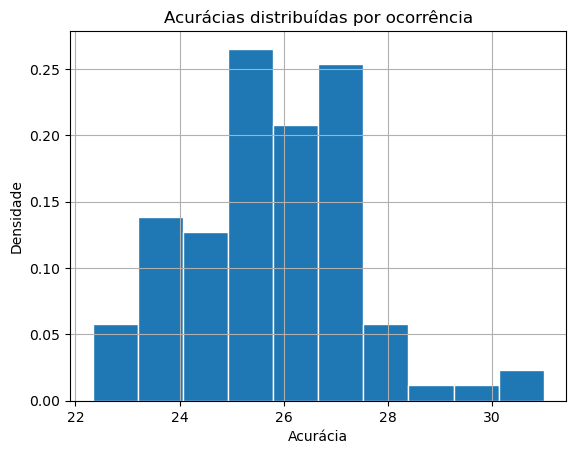

In [39]:
# Criando o histograma
plt.hist(lista_acuracia, edgecolor='white', density=True)

# Configurando a visualização
plt.title("Acurácias distribuídas por ocorrência")
plt.grid(True)
plt.xlabel('Acurácia')
plt.ylabel('Densidade')

# Mostrando o gráfico
plt.show()


Com base no gráfico, percebe-se que a acurácia média é até maior do que a obtida com o a base de dados 'teste', porém, raramente supera os 30%. Assim, é possível perceber que o nosso classificador opera nessa faixa e produz resultados coerentes variando cerca de 10% na acurácia.

___
## Aperfeiçoamento:

Trabalhos que conseguirem pelo menos conceito B vão evoluir em conceito dependendo da quantidade de itens avançados:

* IMPLEMENTOU outras limpezas e transformações que não afetem a qualidade da informação contida nos tweets. Ex: stemming, lemmatization, stopwords
* CONSIDEROU mais de duas categorias na variável Target e INCREMENTOU a quantidade de notícias, mantendo pelo menos 250 notícias por categoria (OBRIGATÓRIO PARA TRIOS, sem contar como item avançado)
* Para Target com duas categorias: CRIOU pelo menos quatro categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante
* EXPLICOU porquê não pode usar o próprio classificador para gerar mais amostras de treinamento
* PROPÔS diferentes cenários para Naïve Bayes fora do contexto do projeto (pelo menos dois cenários, exceto aqueles já apresentados em sala pelos professores: por exemplo, filtro de spam)
* SUGERIU e EXPLICOU melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)
* FEZ o item Qualidade do Classificador a partir de novas separações das Notícias entre Treinamento e Teste descrito no enunciado do projeto (OBRIGATÓRIO para conceitos A ou A+)

___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**

[Aprendizagem Bayesiana](https://www.inf.ufpr.br/menotti/ci171-182/slides/ci171-bayes.pdf) **UFPR**

[Analytics Vidhy](https://www.analyticsvidhya.com/blog/2021/04/improve-naive-bayes-text-classifier-using-laplace-smoothing/) **Mais sobre a suavização de Laplace**

[Regular expression operations](https://docs.python.org/3/library/re.html#) **Biblioteca para a função cleanup**